# Secondary standard stars

In [1]:
#4.5 4.6


Calculating optimal aperture for: phot_00.fits
  Optimal Aperture: 12 px

Calculating optimal aperture for: phot_01.fits
  Optimal Aperture: 10 px

Calculating optimal aperture for: phot_02.fits
  Optimal Aperture: 10 px

Calculating optimal aperture for: phot_03.fits
  Optimal Aperture: 10 px

Calculating optimal aperture for: phot_04.fits
  Optimal Aperture: 11 px

Calculating optimal aperture for: phot_05.fits
  Optimal Aperture: 12 px

Calculating optimal aperture for: phot_06.fits
  Optimal Aperture: 12 px

Calculating optimal aperture for: phot_07.fits
  Optimal Aperture: 12 px

Calculating optimal aperture for: phot_08.fits
  Optimal Aperture: 12 px

Calculating optimal aperture for: phot_09.fits
  Optimal Aperture: 11 px

Calculating optimal aperture for: phot_10.fits
  Optimal Aperture: 10 px

Calculating optimal aperture for: phot_11.fits
  Optimal Aperture: 12 px

Calculating optimal aperture for: phot_12.fits
  Optimal Aperture: 12 px

Calculating optimal aperture for: pho

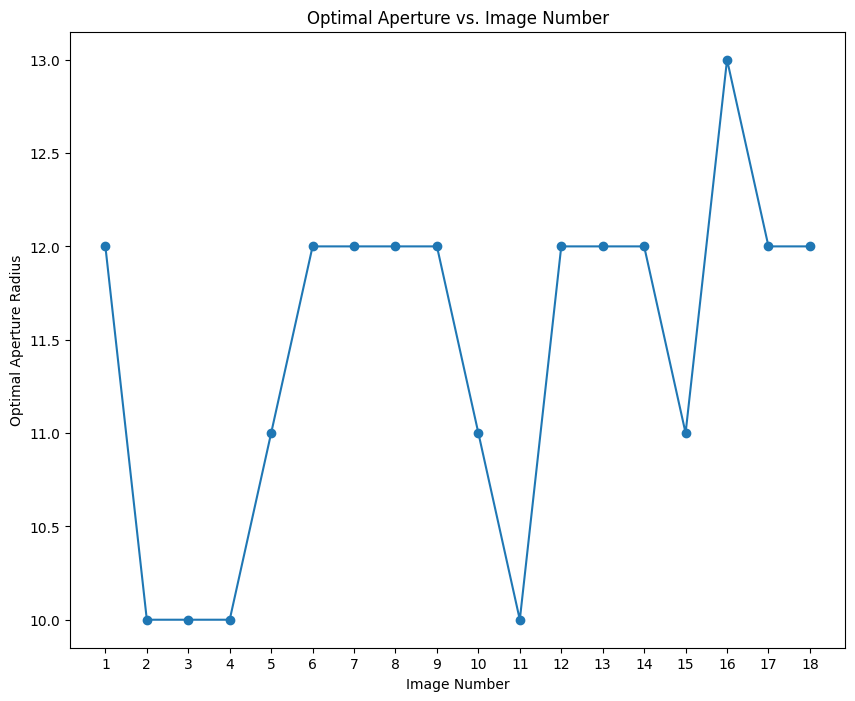


Variability Check Results:
    id  mean_inst_mag  std_dev_inst_mag  is_stable
0   76            NaN               NaN      False
1  115            NaN               NaN      False
2  110            NaN               NaN      False
3   59      34.041334          0.325783      False
4   99            NaN               NaN      False
5  123            NaN               NaN      False
6   39      34.187201          0.336811      False
7   49      34.191126          0.335764      False
8  118            NaN               NaN      False
9    8      34.344546          0.346581      False


In [13]:
import astropy
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astroquery.simbad import Simbad
from astropy.wcs import WCS
import warnings
from astropy.wcs import FITSFixedWarning

warnings.filterwarnings('ignore', category=FITSFixedWarning, message=".*'datfix' made the change.*")

# --- 0. Setup ---
wd = r"C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\2"
os.chdir(wd)
plt.rcParams['figure.figsize'] = [10, 8]

# --- 1. Load Calibration Star Data ---
calibration_stars_df = pd.read_csv('new_calibration_stars.csv')

# --- 2. Load Image Files ---
phot_files = [f for f in os.listdir(wd) if f.startswith('phot_') and f.endswith('.fits')]
phot_files.sort()

# --- 3. Define Nova's Coordinates ---
ra_nova = 11.176088536435575  # RA of the nova
dec_nova = 40.140699048618714  # DEC of the nova

# --- 4. Photometry Functions ---
def phot_counts(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area

    tot_counts = phot_tbl['aperture_sum_0'][0]
    return tot_counts, bkg_sum, ap.area

def calc_snr(tot_counts, bkg_counts, ap_area):
    mean_counts = (tot_counts - bkg_counts) / ap_area
    if tot_counts + bkg_counts <= 0:
        print("Warning: Negative counts. Returning SNR = 0")
        return 0.0
    err_counts = np.sqrt(tot_counts + bkg_counts) / ap_area
    return mean_counts / err_counts

def phot_mag(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area

    final_sum = phot_tbl['aperture_sum_0'][0] - bkg_sum
    if final_sum > 0:
        inst_mag = -2.5 * np.log10(final_sum) + 50
        mag_err = 1.0857 * (np.sqrt(phot_tbl['aperture_sum_0'][0] + bkg_sum) / final_sum)
        if np.isnan(inst_mag):
            print(f"Warning: inst_mag is NaN for x={x}, y={y}, ap_rad={ap_rad}")
    else:
        inst_mag = np.nan
        mag_err = np.nan
    return inst_mag, mag_err, bkg_med

# --- 5. Optimal Aperture Calculation ---
ap_radii_snr = np.arange(5, 40, 1)
in_ann, out_ann = 25, 35
opt_ap = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        hdr = hdu[0].header
        wcs = WCS(hdr)
        if img.dtype.byteorder == '>':
            img = img.byteswap().view(img.dtype.newbyteorder('<'))

        # Convert RA and DEC of the nova to pixel coordinates
        nx, ny = wcs.all_world2pix(ra_nova, dec_nova, 1)

        print(f"\nCalculating optimal aperture for: {f}")
        snrs = []
        for ap_rad in ap_radii_snr:
            tot_counts, bkg_counts, ap_area = phot_counts(img, nx, ny, ap_rad, in_ann, out_ann)
            if tot_counts + bkg_counts <= 0:
                print(f"Warning: Negative counts in {f}, aperture: {ap_rad}")
                snrs.append(0.0)
            else:
                snr = calc_snr(tot_counts, bkg_counts, ap_area)
                snrs.append(snr)

        opt_ap_rad = ap_radii_snr[np.argmax(snrs)]
        opt_ap.append(opt_ap_rad)
        print(f"  Optimal Aperture: {opt_ap_rad} px")

# --- 6. Perform Photometry on Nova and Calibration Stars ---
photometry_results = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        hdr = hdu[0].header
        wcs = WCS(hdr)
        if img.dtype.byteorder == '>':
            img = img.byteswap().view(img.dtype.newbyteorder('<'))

        print(f"\nPerforming photometry on: {f}")
        opt_ap_rad = opt_ap[i]

        # Nova
        nx, ny = wcs.all_world2pix(ra_nova, dec_nova, 1)
        inst_mag_nova, mag_err_nova, bkg_med_nova = phot_mag(img, nx, ny, opt_ap_rad, in_ann, out_ann)

        photometry_results.append({
            'image': f,
            'mjd': hdr['MJD'],
            'obj_type': 'nova',
            'id': 'nova',
            'ra': ra_nova,
            'dec': dec_nova,
            'x': nx,
            'y': ny,
            'opt_ap': opt_ap_rad,
            'inst_mag': inst_mag_nova,
            'mag_err': mag_err_nova,
            'bkg_med': bkg_med_nova,
            'r_prime': np.nan,  # Placeholder, to be filled in later
            'r_prime_err': np.nan,  # Placeholder, to be filled in later
        })

        # Calibration Stars
        for index, row in calibration_stars_df.iterrows():
            try:
                # Convert RA and DEC to pixel coordinates
                x, y = wcs.all_world2pix(row['RAJ2000'], row['DEJ2000'], 1)
                inst_mag, mag_err, bkg_med = phot_mag(img, x, y, opt_ap_rad, in_ann, out_ann)

                # PS1-to-Sloan transformation (example for r' band)
                # Tonry et al. (2012): r' = r - 0.003 - 0.146*(g - r)
                g = row['gmag']
                r = row['rmag']
                g_r = g - r
                r_prime = r - 0.003 - 0.146 * g_r
                r_prime_err = np.sqrt(row['e_gmag']**2 + row['e_rmag']**2)  # Combined error

                photometry_results.append({
                    'image': f,
                    'mjd': hdr['MJD'],
                    'obj_type': 'calibration_star',
                    'id': row['ID'],
                    'ra': row['RAJ2000'],
                    'dec': row['DEJ2000'],
                    'x': x,
                    'y': y,
                    'opt_ap': opt_ap_rad,
                    'inst_mag': inst_mag,
                    'mag_err': mag_err,
                    'bkg_med': bkg_med,
                    'r_prime': r_prime,
                    'r_prime_err': r_prime_err,
                })

            except Exception as e:
                print(f"Error processing star {row['ID']} in image {f}: {e}")

# --- 7. Validate Secondary Standards ---
# Check the variability of secondary standards across all images
secondary_star_ids = calibration_stars_df['ID'].unique()
variability_check = []

for star_id in secondary_star_ids:
    star_measurements = [result for result in photometry_results if result['id'] == star_id]
    inst_mags = [result['inst_mag'] for result in star_measurements if not np.isnan(result['inst_mag'])]
    mag_std_dev = np.std(inst_mags) if len(inst_mags) > 1 else np.nan
    variability_check.append({
        'id': star_id,
        'mean_inst_mag': np.mean(inst_mags) if len(inst_mags) > 0 else np.nan,
        'std_dev_inst_mag': mag_std_dev,
        'is_stable': mag_std_dev < 0.05 if not np.isnan(mag_std_dev) else False  # Arbitrary threshold for stability
    })

variability_df = pd.DataFrame(variability_check)
variability_df.to_csv('variability_check.csv', index=False)

# --- 8. Save Photometry Results ---
photometry_results_df = pd.DataFrame(photometry_results)
photometry_results_df.to_csv('photometry_results.csv', index=False)

# --- 9. Plot Optimal Aperture vs. Image Number ---
plt.figure()
plt.plot(range(1, len(phot_files) + 1), opt_ap, 'o-')
plt.xlabel("Image Number")
plt.ylabel("Optimal Aperture Radius")
plt.title("Optimal Aperture vs. Image Number")
plt.xticks(range(1, len(phot_files) + 1))
plt.show()

# --- 10. Summarize Variability Check ---
print("\nVariability Check Results:")
print(variability_df)


In [12]:
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
import os

# Set working directory
wd = r"C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\2"
os.chdir(wd)

# Load the catalog
cat = pd.read_csv('psdr1_new.tsv', sep='\t')

# Ensure relevant columns are numeric
numeric_columns = ["RAJ2000", "DEJ2000", "e_rmag", "e_gmag", "rmag"]
for col in numeric_columns:
    cat[col] = pd.to_numeric(cat[col], errors="coerce")

# Drop rows with NaN values in critical columns
cat = cat.dropna(subset=["RAJ2000", "DEJ2000", "e_rmag", "e_gmag", "rmag"]).reset_index(drop=True)

# Define nova coordinates
nova_ra = 11.176088536435575  # RA of the nova in degrees
nova_dec = 40.140699048618714  # DEC of the nova in degrees
nova_coord = SkyCoord(ra=nova_ra * u.deg, dec=nova_dec * u.deg)

# Define thresholds for selection
max_uncertainty = 0.05  # Maximum allowed uncertainty for photometric measurements
min_distance_arcsec = 10  # Minimum separation from the nova in arcseconds

# Add distance to the nova for each star
catalog_coords = SkyCoord(ra=cat["RAJ2000"].values * u.deg, dec=cat["DEJ2000"].values * u.deg)
separation = catalog_coords.separation(nova_coord).arcsecond
cat["Separation_arcsec"] = separation

# Filter the catalog to find new stars
filtered_catalog = cat[
    (cat["e_rmag"] < max_uncertainty) &  # Uncertainty in r-band
    (cat["e_gmag"] < max_uncertainty) &  # Uncertainty in g-band
    (cat["Separation_arcsec"] > min_distance_arcsec)  # Minimum distance from nova
]

# Sort the filtered catalog by r-band magnitude for convenience
filtered_catalog = filtered_catalog.sort_values(by="rmag")

# Select the first 10 stars from the filtered catalog for calibration
new_cal_stars = filtered_catalog.head(10)

# Save the new calibration stars
new_cal_stars.to_csv('new_calibration_stars.csv', index=False)

# Output the results
print("New Calibration Stars Data:")
print(new_cal_stars)


New Calibration Stars Data:
      ID      _r      _RAJ2000      _DEJ2000    RAJ2000    DEJ2000  \
75    76  5.3171  00:44:13.502  +40:07:53.08  11.056259  40.131412   
114  115  6.6566  00:44:35.166  +40:15:09.30  11.146526  40.252584   
109  110  6.5541  00:44:40.710  +40:02:02.46  11.169625  40.034015   
58    59  4.7625  00:44:42.790  +40:03:50.61  11.178294  40.064058   
98    99  6.2293  00:44:08.827  +40:07:41.40  11.036778  40.128166   
122  123  6.8324  00:45:02.196  +40:14:06.54  11.259150  40.235151   
38    39  4.0544  00:44:57.464  +40:11:10.20  11.239433  40.186167   
48    49  4.4841  00:44:19.113  +40:10:10.59  11.079639  40.169609   
117  118  6.7683  00:44:32.884  +40:02:00.61  11.137015  40.033502   
7      8  1.8871  00:44:40.081  +40:10:28.33  11.167005  40.174537   

                  objID    f_objID Qual  Ns  ...     rmag  e_rmag    rFlags  \
75   156150110562608356  503635968   60   5  ...  13.6666  0.0008  16892216   
114  156300111465423780  503635968   60   5

In [14]:
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
import numpy as np
import os

# --- Setup ---
wd = r"C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\2"
os.chdir(wd)

# Load calibration stars and images
calibration_stars_df = pd.read_csv('new_calibration_stars.csv')  # Updated calibration stars file
phot_files = [f for f in os.listdir(wd) if f.startswith('phot_') and f.endswith('.fits')]
phot_files.sort()

# Define nova coordinates
ra_nova = 11.176088536435575
dec_nova = 40.140699048618714

# --- Photometry Functions ---
def phot_counts(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area

    tot_counts = phot_tbl['aperture_sum_0'][0]
    return tot_counts, bkg_sum, ap.area

def calc_snr(tot_counts, bkg_counts, ap_area):
    mean_counts = (tot_counts - bkg_counts) / ap_area
    if tot_counts + bkg_counts <= 0:
        return 0.0
    err_counts = np.sqrt(tot_counts + bkg_counts) / ap_area
    return mean_counts / err_counts

def phot_mag(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area

    final_sum = phot_tbl['aperture_sum_0'][0] - bkg_sum
    if final_sum > 0:
        inst_mag = -2.5 * np.log10(final_sum) + 50
        mag_err = 1.0857 * (np.sqrt(phot_tbl['aperture_sum_0'][0] + bkg_sum) / final_sum)
        return inst_mag, mag_err, bkg_med
    else:
        return np.nan, np.nan, bkg_med

# --- Optimal Aperture Calculation ---
ap_radii_snr = np.arange(5, 40, 1)
in_ann, out_ann = 25, 35
opt_ap = []

# Perform optimal aperture calculation for each image
for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        hdr = hdu[0].header
        wcs = WCS(hdr)

        nx, ny = wcs.all_world2pix(ra_nova, dec_nova, 1)
        snrs = []
        for ap_rad in ap_radii_snr:
            tot_counts, bkg_counts, ap_area = phot_counts(img, nx, ny, ap_rad, in_ann, out_ann)
            snr = calc_snr(tot_counts, bkg_counts, ap_area)
            snrs.append(snr)

        opt_ap_rad = ap_radii_snr[np.argmax(snrs)]
        opt_ap.append(opt_ap_rad)
        print(f"Optimal Aperture for {f}: {opt_ap_rad} px")

# --- Perform Photometry ---
photometry_results = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        hdr = hdu[0].header
        wcs = WCS(hdr)

        print(f"\nPerforming photometry on: {f}")
        opt_ap_rad = opt_ap[i]

        # Nova photometry
        nx, ny = wcs.all_world2pix(ra_nova, dec_nova, 1)
        inst_mag_nova, mag_err_nova, bkg_med_nova = phot_mag(img, nx, ny, opt_ap_rad, in_ann, out_ann)
        photometry_results.append({
            'image': f,
            'mjd': hdr.get('MJD', np.nan),
            'obj_type': 'nova',
            'id': 'nova',
            'ra': ra_nova,
            'dec': dec_nova,
            'x': nx,
            'y': ny,
            'opt_ap': opt_ap_rad,
            'inst_mag': inst_mag_nova,
            'mag_err': mag_err_nova,
            'bkg_med': bkg_med_nova,
        })

        # Calibration stars photometry
        for index, row in calibration_stars_df.iterrows():
            try:
                x, y = wcs.all_world2pix(row['RAJ2000'], row['DEJ2000'], 1)
                if not (0 <= x < img.shape[1] and 0 <= y < img.shape[0]):
                    raise ValueError(f"Aperture for star {row['ID']} is outside the field of view.")
                inst_mag, mag_err, bkg_med = phot_mag(img, x, y, opt_ap_rad, in_ann, out_ann)
                photometry_results.append({
                    'image': f,
                    'mjd': hdr.get('MJD', np.nan),
                    'obj_type': 'calibration_star',
                    'id': row['ID'],
                    'ra': row['RAJ2000'],
                    'dec': row['DEJ2000'],
                    'x': x,
                    'y': y,
                    'opt_ap': opt_ap_rad,
                    'inst_mag': inst_mag,
                    'mag_err': mag_err,
                    'bkg_med': bkg_med,
                })
            except Exception as e:
                print(f"Error processing star {row['ID']} in image {f}: {e}")

# Save results
photometry_results_df = pd.DataFrame(photometry_results)
photometry_results_df.to_csv('photometry_results.csv', index=False)

print("\nPhotometry complete. Results saved to 'photometry_results.csv'.")


Optimal Aperture for phot_00.fits: 12 px
Optimal Aperture for phot_01.fits: 10 px
Optimal Aperture for phot_02.fits: 10 px
Optimal Aperture for phot_03.fits: 10 px
Optimal Aperture for phot_04.fits: 11 px
Optimal Aperture for phot_05.fits: 12 px
Optimal Aperture for phot_06.fits: 12 px
Optimal Aperture for phot_07.fits: 12 px
Optimal Aperture for phot_08.fits: 12 px
Optimal Aperture for phot_09.fits: 11 px
Optimal Aperture for phot_10.fits: 10 px
Optimal Aperture for phot_11.fits: 12 px
Optimal Aperture for phot_12.fits: 12 px
Optimal Aperture for phot_13.fits: 12 px
Optimal Aperture for phot_14.fits: 11 px
Optimal Aperture for phot_15.fits: 13 px
Optimal Aperture for phot_16.fits: 12 px
Optimal Aperture for phot_17.fits: 12 px

Performing photometry on: phot_00.fits
Error processing star 76 in image phot_00.fits: Aperture for star 76 is outside the field of view.
Error processing star 115 in image phot_00.fits: Aperture for star 115 is outside the field of view.
Error processing star 

In [16]:
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
import numpy as np
import os

# --- Setup ---
wd = r"C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\2"
os.chdir(wd)

# Load calibration stars and images
calibration_stars_df = pd.read_csv('new_calibration_stars.csv')  # Updated calibration stars file
phot_files = [f for f in os.listdir(wd) if f.startswith('phot_') and f.endswith('.fits')]
phot_files.sort()

# Define nova coordinates
ra_nova = 11.176088536435575
dec_nova = 40.140699048618714

# --- Photometry Functions ---
def phot_counts(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area

    tot_counts = phot_tbl['aperture_sum_0'][0]
    return tot_counts, bkg_sum, ap.area

def calc_snr(tot_counts, bkg_counts, ap_area):
    mean_counts = (tot_counts - bkg_counts) / ap_area
    if tot_counts + bkg_counts <= 0:
        return 0.0
    err_counts = np.sqrt(tot_counts + bkg_counts) / ap_area
    return mean_counts / err_counts

def phot_mag(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area

    final_sum = phot_tbl['aperture_sum_0'][0] - bkg_sum
    if final_sum > 0:
        inst_mag = -2.5 * np.log10(final_sum) + 50
        mag_err = 1.0857 * (np.sqrt(phot_tbl['aperture_sum_0'][0] + bkg_sum) / final_sum)
        return inst_mag, mag_err, bkg_med
    else:
        return np.nan, np.nan, bkg_med

# --- Optimal Aperture Calculation ---
ap_radii_snr = np.arange(5, 40, 1)
in_ann, out_ann = 25, 35
opt_ap = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        hdr = hdu[0].header
        wcs = WCS(hdr)

        nx, ny = wcs.all_world2pix(ra_nova, dec_nova, 1)
        snrs = []
        for ap_rad in ap_radii_snr:
            tot_counts, bkg_counts, ap_area = phot_counts(img, nx, ny, ap_rad, in_ann, out_ann)
            snr = calc_snr(tot_counts, bkg_counts, ap_area)
            snrs.append(snr)

        opt_ap_rad = ap_radii_snr[np.argmax(snrs)]
        opt_ap.append(opt_ap_rad)
        print(f"Optimal Aperture for {f}: {opt_ap_rad} px")

# --- Perform Photometry ---
photometry_results = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        hdr = hdu[0].header
        wcs = WCS(hdr)

        print(f"\nPerforming photometry on: {f}")
        opt_ap_rad = opt_ap[i]

        # Nova photometry
        nx, ny = wcs.all_world2pix(ra_nova, dec_nova, 1)
        inst_mag_nova, mag_err_nova, bkg_med_nova = phot_mag(img, nx, ny, opt_ap_rad, in_ann, out_ann)
        photometry_results.append({
            'image': f,
            'mjd': hdr.get('MJD', np.nan),
            'obj_type': 'nova',
            'id': 'nova',
            'ra': ra_nova,
            'dec': dec_nova,
            'x': nx,
            'y': ny,
            'opt_ap': opt_ap_rad,
            'inst_mag': inst_mag_nova,
            'mag_err': mag_err_nova,
            'bkg_med': bkg_med_nova,
        })

        # Calibration stars photometry
        for index, row in calibration_stars_df.iterrows():
            try:
                x, y = wcs.all_world2pix(row['RAJ2000'], row['DEJ2000'], 1)
                if not (0 <= x < img.shape[1] and 0 <= y < img.shape[0]):
                    raise ValueError(f"Aperture for star {row['ID']} is outside the field of view.")

                inst_mag, mag_err, bkg_med = phot_mag(img, x, y, opt_ap_rad, in_ann, out_ann)

                # PS1-to-Sloan transformation
                g = row['gmag']
                r = row['rmag']
                g_r = g - r
                r_prime = r - 0.003 - 0.146 * g_r
                r_prime_err = np.sqrt(row['e_gmag']**2 + row['e_rmag']**2)  # Combined uncertainty

                photometry_results.append({
                    'image': f,
                    'mjd': hdr.get('MJD', np.nan),
                    'obj_type': 'calibration_star',
                    'id': row['ID'],
                    'ra': row['RAJ2000'],
                    'dec': row['DEJ2000'],
                    'x': x,
                    'y': y,
                    'opt_ap': opt_ap_rad,
                    'inst_mag': inst_mag,
                    'mag_err': mag_err,
                    'bkg_med': bkg_med,
                    'r_prime': r_prime,
                    'r_prime_err': r_prime_err,
                })
            except Exception as e:
                print(f"Error processing star {row['ID']} in image {f}: {e}")

# --- Weighted Calibration ---
calibrated_results = []

for i, f in enumerate(phot_files):
    image_results = [r for r in photometry_results if r['image'] == f and r['obj_type'] == 'calibration_star']

    if not image_results:
        print(f"No calibration stars processed for image {f}. Skipping.")
        continue

    catalog_mags = np.array([row['r_prime'] for row in image_results if not np.isnan(row['r_prime'])])
    instrumental_mags = np.array([row['inst_mag'] for row in image_results if not np.isnan(row['inst_mag'])])
    uncertainties = np.array([row['mag_err'] for row in image_results if not np.isnan(row['mag_err'])])

    weights = 1 / uncertainties**2
    zero_point = np.sum((catalog_mags - instrumental_mags) * weights) / np.sum(weights)

    print(f"Calculated Zero-Point for {f}: {zero_point:.3f}")

    nova_result = next((r for r in photometry_results if r['image'] == f and r['obj_type'] == 'nova'), None)
    if nova_result and not np.isnan(nova_result['inst_mag']):
        calibrated_mag = nova_result['inst_mag'] + zero_point
        calibrated_results.append({
            'image': f,
            'mjd': nova_result['mjd'],
            'calibrated_mag': calibrated_mag,
            'inst_mag': nova_result['inst_mag'],
            'zero_point': zero_point,
        })

# Save calibrated results
calibrated_results_df = pd.DataFrame(calibrated_results)
calibrated_results_df.to_csv('calibrated_nova_results.csv', index=False)

print("\nCalibration complete. Results saved to 'calibrated_nova_results.csv'.")


Optimal Aperture for phot_00.fits: 12 px
Optimal Aperture for phot_01.fits: 10 px
Optimal Aperture for phot_02.fits: 10 px
Optimal Aperture for phot_03.fits: 10 px
Optimal Aperture for phot_04.fits: 11 px
Optimal Aperture for phot_05.fits: 12 px
Optimal Aperture for phot_06.fits: 12 px
Optimal Aperture for phot_07.fits: 12 px
Optimal Aperture for phot_08.fits: 12 px
Optimal Aperture for phot_09.fits: 11 px
Optimal Aperture for phot_10.fits: 10 px
Optimal Aperture for phot_11.fits: 12 px
Optimal Aperture for phot_12.fits: 12 px
Optimal Aperture for phot_13.fits: 12 px
Optimal Aperture for phot_14.fits: 11 px
Optimal Aperture for phot_15.fits: 13 px
Optimal Aperture for phot_16.fits: 12 px
Optimal Aperture for phot_17.fits: 12 px

Performing photometry on: phot_00.fits
Error processing star 76 in image phot_00.fits: Aperture for star 76 is outside the field of view.
Error processing star 115 in image phot_00.fits: Aperture for star 115 is outside the field of view.
Error processing star 